### 1. Data Collection

In [4]:
import requests
from requests.adapters import HTTPAdapter, Retry # Needed to implement retrial process
import json
import re 

In [5]:
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

In [7]:
def get_next_link(headers):
    if "Link" in headers:
        # The regular expression is used to extract the next link for pagination
        re_next_link = re.compile(r'<(.+)>; rel="next"')
        match = re_next_link.match(headers["Link"]) # 
        if match:
            return match.group(1)

# This function actually retrieve the next data batch in the search.
# The function act as an iterator, yielding the next result batch at every call
# The function terminates after the last batch has been returned. In this case,
# the next link will be None

# This is a generator function that takes the batch url (what we get from the website after the advanced search)
def get_batch(batch_url): 
    while batch_url:
        # Run the API call 
        response = session.get(batch_url)
        # Will raise an error if an error status code is obtained
        response.raise_for_status()
        # Get the total number of entries in the search after the batch retrieval has been completed
        total = response.headers["x-total-results"]
        # Yield the response and the total number of entries
        yield response, total
        # Get the link to the API call for the next data batch. I just got the first batch, then yield it and get the link of the next batch
        batch_url = get_next_link(response.headers)

In [8]:
batch_size = 500
url = "https://rest.uniprot.org/uniprotkb/search?format=json&query=%28%28taxonomy_id%3A2759%29+AND+%28length%3A%5B40+TO+*%5D+AND+reviewed%3Atrue+AND+ft_signal_exp%3A*%29%29&size=500"

In [37]:
def filter_entry(entry):
    for feature in entry["features"]:
        if feature["type"] == "Signal":
            if feature["location"]["end"]["value"] != "?"  and feature["location"]["end"]["value"] is not None and feature["location"]["end"]["value"] > 14 and feature["description"] != "Not cleaved":              
                return True
    return False

In [29]:
'''def extract_fields(entry):
        acc = entry["primaryAccession"]
        org = entry["organism"]
        for f in entry["features"]:
                print(f)
                '''

In [33]:
def get_dataset(search_url,filter_function):
    filtered_json = []
    n_total, n_filtered = 0, 0
    # Run the API call in batches
    for batch, total in get_batch(search_url):
        batch_json = json.loads(batch.text)
        
        for entry in batch_json["results"]:
            n_total += 1
            if filter_function(entry):
                n_filtered += 1
                filtered_json.append(entry)
    print(n_total, n_filtered)





In [38]:
get_dataset(url,filter_entry)

2964 2930


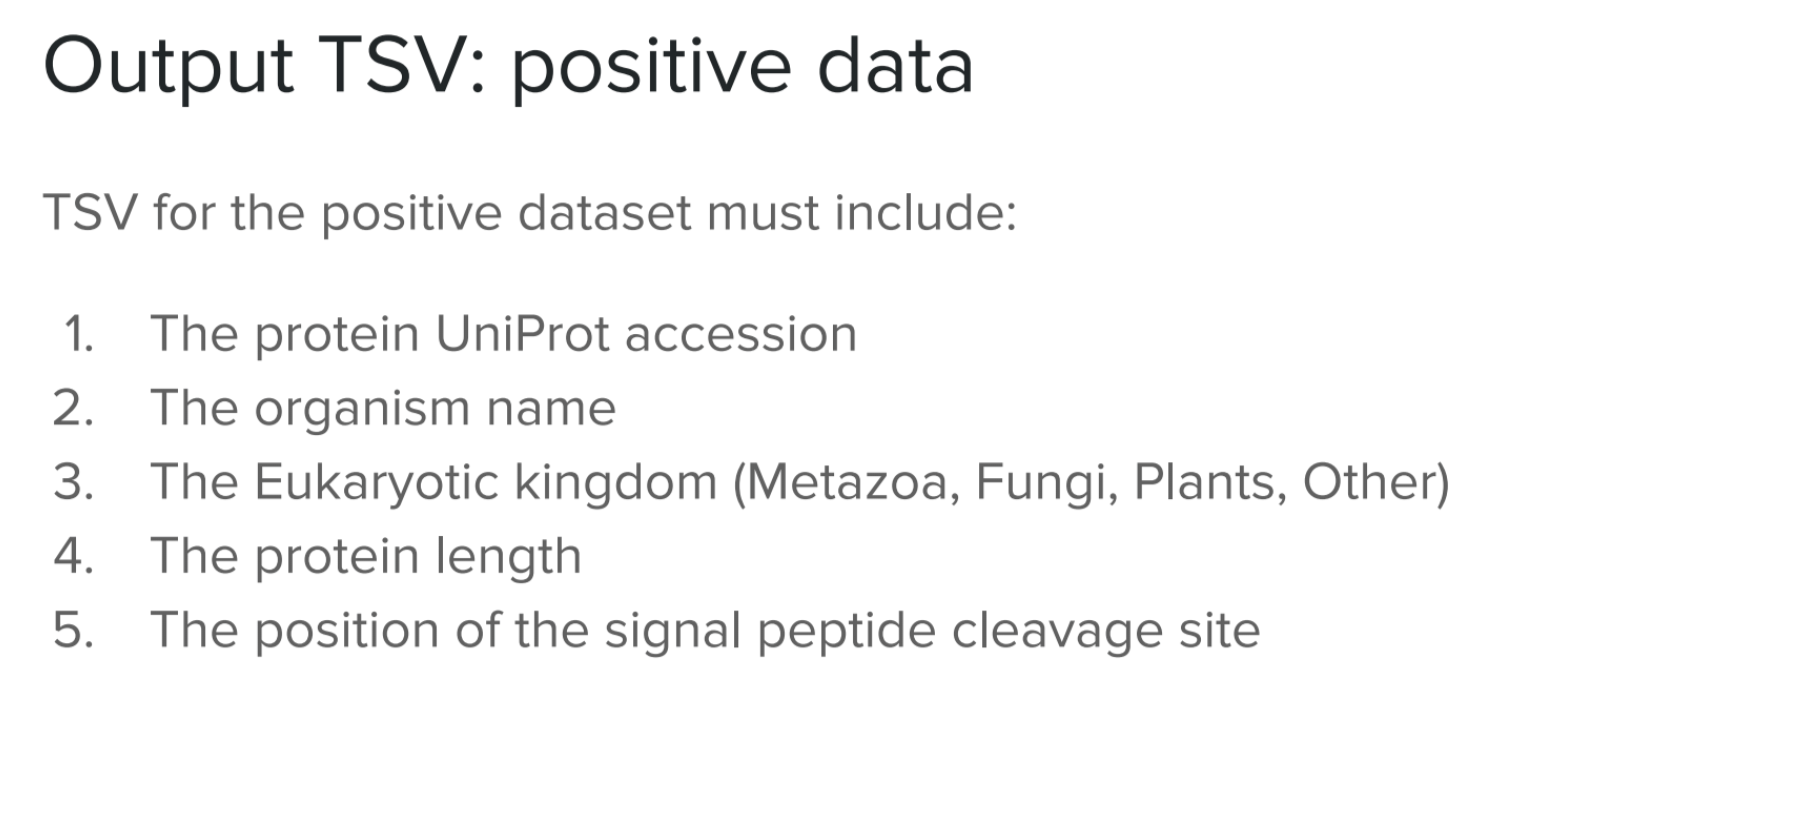

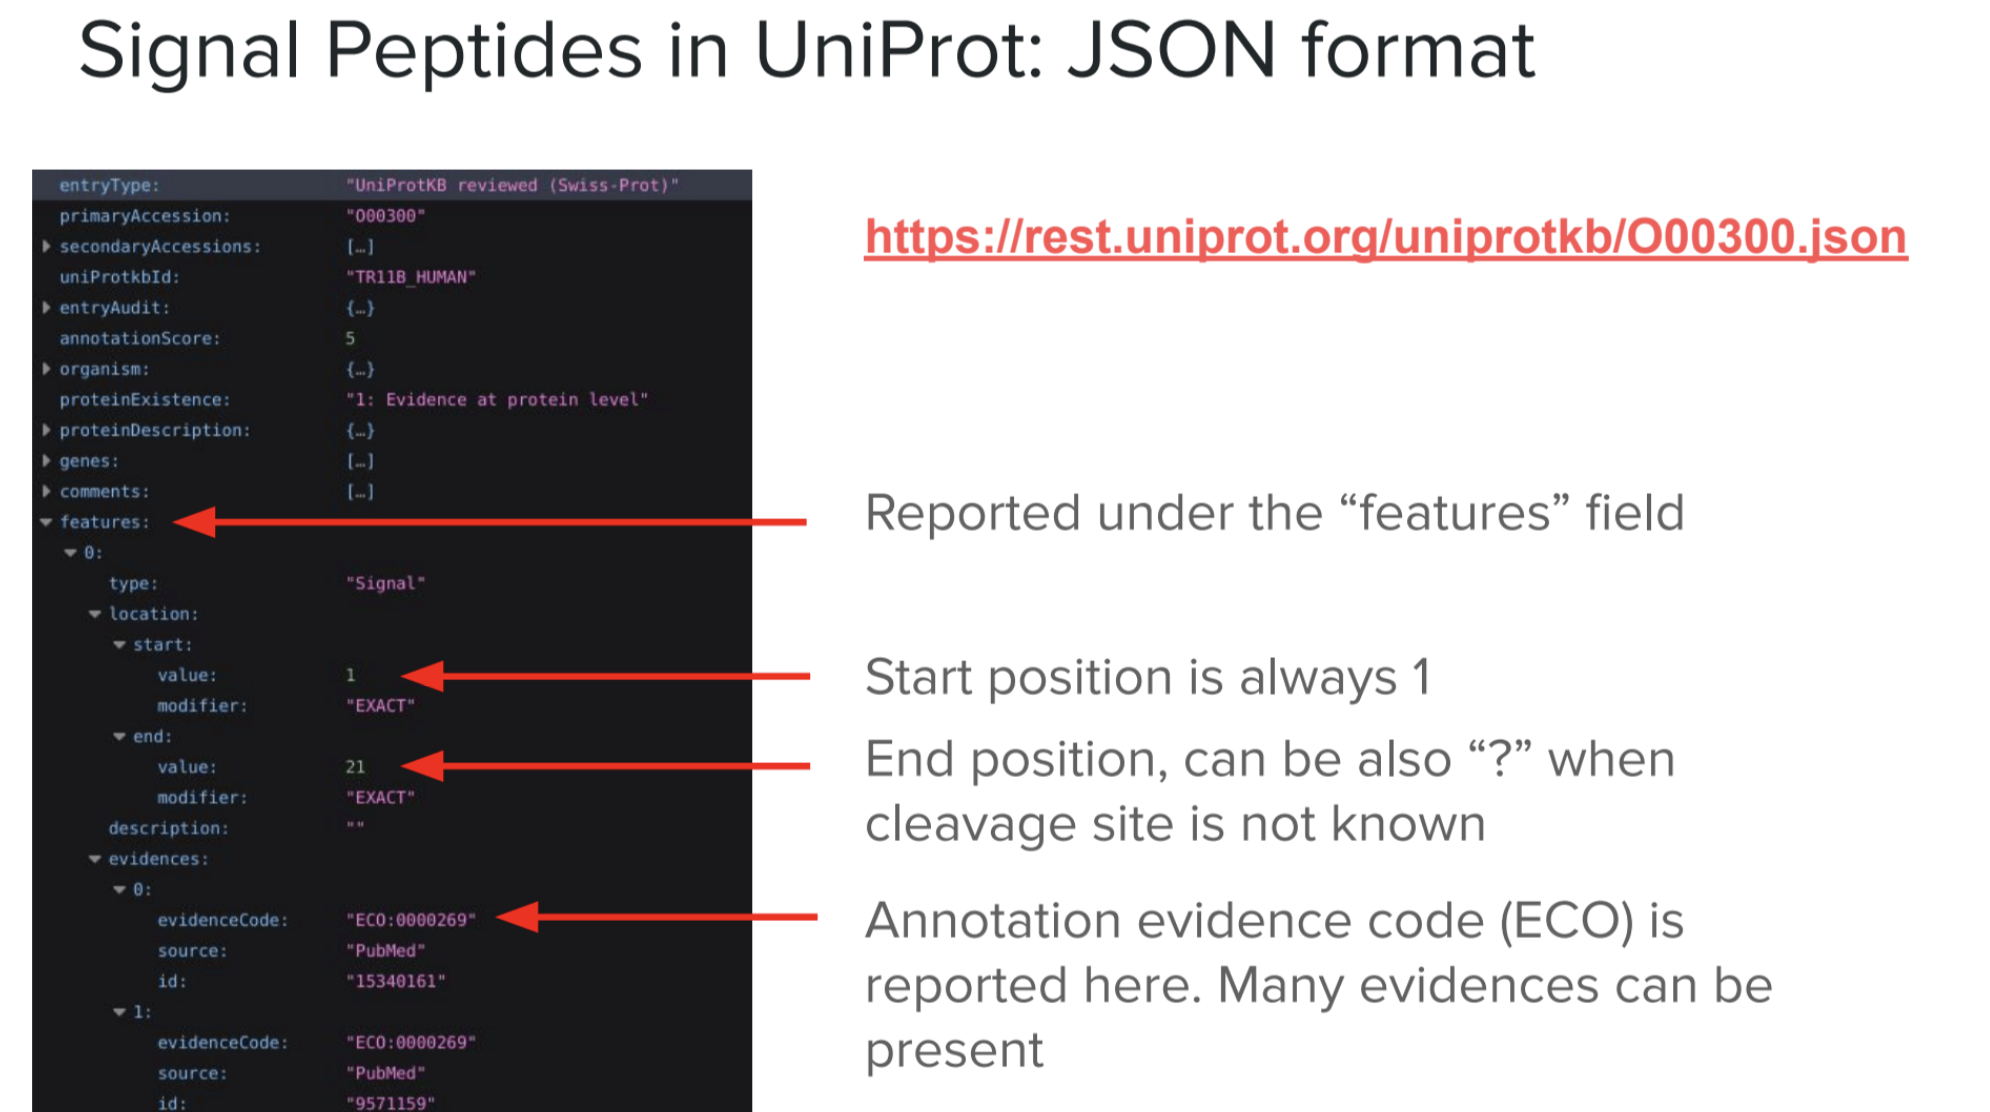